# Analysis of links between behaviour and mechanical signals

&copy; Fouad Baamal, JJ Aucouturier, 2025

In [1]:
import pandas as pd
import os.path
import numpy as np
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import pingouin as pg
import openpyxl
import re
from scipy import signal

# All Data :

## 1. Load data

### ALL data

In [2]:
for i in glob.glob("./data/meca/series/*") :
    print(i)

./data/meca/series\Sujet 06
./data/meca/series\Sujet 07
./data/meca/series\Sujet 08
./data/meca/series\Sujet 09
./data/meca/series\Sujet 10
./data/meca/series\Sujet 11
./data/meca/series\Sujet 12
./data/meca/series\Sujet 13
./data/meca/series\Sujet 14
./data/meca/series\Sujet 15
./data/meca/series\Sujet 16
./data/meca/series\Sujet 17
./data/meca/series\Sujet 18
./data/meca/series\Sujet 19
./data/meca/series\Sujet 21
./data/meca/series\Sujet 22
./data/meca/series\Sujet 23
./data/meca/series\Sujet 24
./data/meca/series\Sujet 25
./data/meca/series\Sujet 26
./data/meca/series\Sujet 27


In [3]:
if False : 
    def resample_all_cols(df, sr, new_sr, time_col='Time [s]'):
        """
        Resample selected data columns of a DataFrame from sr to new_sr.
        
        Parameters:
        - df: input DataFrame
        - sr: original sampling rate (Hz)
        - new_sr: target sampling rate (Hz)
        - time_col: name of the time column
        
        Returns:
        - resampled DataFrame
        """
        # List of columns to resample
        data_cols = ['Displacement [mm]', 'Fn [N]','Ft [N]', 'COF []', 'Acceleration [m/s²]']
        data_cols = [col for col in data_cols if col in df.columns]
        
        # Time array
        time = np.array(df[time_col])
        n_samples = int((len(time) / sr) * new_sr) 

        # Resample each data column
        resampled_data = {}
        for col in data_cols:
            resampled_data[col], new_time = signal.resample(
                np.array(df[col]), num=n_samples, t=time
            )
        
        # Construct new DataFrame
        resampled_df = pd.DataFrame(resampled_data)
        resampled_df[time_col] = new_time
        
        return resampled_df
    cols = ['Time [s]', 'Displacement [mm]', 'Fn [N]', 'Ft [N]', 'COF []', 'Acceleration [m/s²]']

In [4]:
if False :
    data = pd.DataFrame()
    i = int(input("choisir le nombre de sujet à depouiller : "))
    j = 1
    for subject_files in glob.glob("./data/meca/series/*") :    # load all subjects
        for serie in glob.glob("%s/*"%subject_files) :# load a single file of a Subject
            data_serie = pd.read_excel(serie)
            data_serie[cols] = data_serie[cols].apply(pd.to_numeric)
            resampled_data = resample_all_cols(data_serie, sr=5000, new_sr=100)
            resampled_data['subj'] = int(subject_files[-2:])
            resampled_data['block'] = int(serie[40])
            resampled_data['trial'] = int(serie[42:44])
            resampled_data['stim_order'] = int(serie[53])

            resampled_data['normalised_time'] = np.linspace(1,100,len(resampled_data))
            #resampled_data.periode = resampled_data.periode + 1
            data = pd.concat([data, resampled_data], ignore_index=True)  # add data subject to the previous one
        print("subject file processed : %s"%subject_files)
        if j == i :
            break
        j = j+1

In [5]:
# Enregistrer la dataframe ( Juste pour la première fois : )

#data.to_csv('data/all_data.csv')

In [9]:
data = pd.read_csv('data/all_data.csv',index_col=0)
#data

### removing outliers 

In [10]:
# Generate dataframe with no outliers
filtered = pd.read_csv('data/meca/meca.csv')
filtered.drop(columns=['Unnamed: 0','index'],inplace=True)
filtered.rename(columns={"texture": "stim_order"},inplace=True)

In [11]:
# Remove outliers from data
shared_columns = [col for col in data.columns
                     if col in filtered.columns]
filtered = filtered[shared_columns]
data = pd.merge(data,filtered, on=['subj','block','trial','stim_order'],how='inner')
data

,Displacement [mm],Fn [N],Ft [N],COF [],Acceleration [m/s²],Time [s],subj,block,trial,stim_order,normalised_time
0,21.289894,0.132235,0.403616,3.052261,-1.965516,2.4468,6,1,0,1,1.000000
1,20.772082,0.130869,0.400328,3.058999,-1.472870,2.4470,6,1,0,1,1.041949
2,20.230913,0.129739,0.399671,3.080563,-1.637156,2.4472,6,1,0,1,1.083898
3,19.661823,0.128897,0.400328,3.105799,-1.670056,2.4474,6,1,0,1,1.125847
4,19.084907,0.128146,0.400329,3.124001,-2.162808,2.4476,6,1,0,1,1.167797
...,...,...,...,...,...,...,...,...,...,...,...
15584889,58.631441,1.323029,0.588102,0.444512,1.485856,5.2458,27,4,24,2,99.803669
15584890,58.645615,1.320701,0.590074,0.446789,3.128176,5.2460,27,4,24,2,99.852752
15584891,58.661244,1.318856,0.590403,0.447663,2.931085,5.2462,27,4,24,2,99.901834
15584892,58.678386,1.317370,0.590403,0.448168,1.945676,5.2464,27,4,24,2,99.950917


### Behavioural data

In [12]:
data_df = pd.read_csv('data/behaviour/all_data.csv')
data_df.stim_order = data_df.stim_order +1 
data_df

,subj,trial,block,practice,condition,sex,age,date,data_file,texture_id,stim_order,diameter,opening,spacing,response,rt
0,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857
1,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E064,2,50.0,140.0,190.0,True,10.857
2,6,1,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial1.csv,E061,1,80.0,170.0,250.0,True,11.883
3,6,1,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial1.csv,E006,2,260.0,20.0,280.0,False,11.883
4,6,2,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial2.csv,E048,1,170.0,170.0,340.0,False,10.245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395,27,22,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E078,2,80.0,110.0,190.0,False,8.466
4396,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E038,1,110.0,80.0,190.0,True,7.617
4397,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E076,2,50.0,50.0,100.0,False,7.617
4398,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E044,1,170.0,140.0,310.0,True,7.534


## 2. Join All data and behavioural data

In [13]:
beha_meca_data = pd.merge(data_df, data, on=['subj', 'trial','block','stim_order'])
#beha_meca_data.rename(columns=lambda x: x[0].lower() + x.strip().lower().replace(' ', '_').title()[1:].lower(),inplace=True)  # snake_case
#beha_meca_data.rename(columns=lambda x: re.sub(r'[^a-z0-9_]', '', x.strip().lower().replace(' ', '_')), inplace=True)

In [14]:
pd.set_option('display.max_columns',beha_meca_data.shape[1])
beha_meca_data

,subj,trial,block,practice,condition,sex,age,date,data_file,texture_id,stim_order,diameter,opening,spacing,response,rt,Displacement [mm],Fn [N],Ft [N],COF [],Acceleration [m/s²],Time [s],normalised_time
0,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,21.289894,0.132235,0.403616,3.052261,-1.965516,2.4468,1.000000
1,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,20.772082,0.130869,0.400328,3.058999,-1.472870,2.4470,1.041949
2,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,20.230913,0.129739,0.399671,3.080563,-1.637156,2.4472,1.083898
3,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,19.661823,0.128897,0.400328,3.105799,-1.670056,2.4474,1.125847
4,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,19.084907,0.128146,0.400329,3.124001,-2.162808,2.4476,1.167797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15584889,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E075,2,20.0,20.0,40.0,False,7.534,58.631441,1.323029,0.588102,0.444512,1.485856,5.2458,99.803669
15584890,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E075,2,20.0,20.0,40.0,False,7.534,58.645615,1.320701,0.590074,0.446789,3.128176,5.2460,99.852752
15584891,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E075,2,20.0,20.0,40.0,False,7.534,58.661244,1.318856,0.590403,0.447663,2.931085,5.2462,99.901834
15584892,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E075,2,20.0,20.0,40.0,False,7.534,58.678386,1.317370,0.590403,0.448168,1.945676,5.2464,99.950917


# Kernels :

## 1. Temporal kernels: Fn, Ft, Acc

In [15]:
columns_to_keep = ['subj', 'block', 'trial','Time [s]','stim_order','Fn [N]','Ft [N]','COF []','Acceleration [m/s²]','normalised_time']  # Replace with the columns you want to keep
data_ker = data[[col for col in data.columns if col in columns_to_keep]]
data_ker

,Fn [N],Ft [N],COF [],Acceleration [m/s²],Time [s],subj,block,trial,stim_order,normalised_time
0,0.132235,0.403616,3.052261,-1.965516,2.4468,6,1,0,1,1.000000
1,0.130869,0.400328,3.058999,-1.472870,2.4470,6,1,0,1,1.041949
2,0.129739,0.399671,3.080563,-1.637156,2.4472,6,1,0,1,1.083898
3,0.128897,0.400328,3.105799,-1.670056,2.4474,6,1,0,1,1.125847
4,0.128146,0.400329,3.124001,-2.162808,2.4476,6,1,0,1,1.167797
...,...,...,...,...,...,...,...,...,...,...
15584889,1.323029,0.588102,0.444512,1.485856,5.2458,27,4,24,2,99.803669
15584890,1.320701,0.590074,0.446789,3.128176,5.2460,27,4,24,2,99.852752
15584891,1.318856,0.590403,0.447663,2.931085,5.2462,27,4,24,2,99.901834
15584892,1.317370,0.590403,0.448168,1.945676,5.2464,27,4,24,2,99.950917


### Resample Fn, Ft and Cof to 100 rows (by mean)

In [16]:
mean_data = pd.DataFrame()
mean_columns = [col for col in data_ker.columns
                     if col in ['Fn [N]','Ft [N]', 'COF []', 'subj','block','trial','stim_order']]
mean_data[mean_columns] = data_ker[mean_columns]
mean_data

,Fn [N],Ft [N],COF [],subj,block,trial,stim_order
0,0.132235,0.403616,3.052261,6,1,0,1
1,0.130869,0.400328,3.058999,6,1,0,1
2,0.129739,0.399671,3.080563,6,1,0,1
3,0.128897,0.400328,3.105799,6,1,0,1
4,0.128146,0.400329,3.124001,6,1,0,1
...,...,...,...,...,...,...,...
15584889,1.323029,0.588102,0.444512,27,4,24,2
15584890,1.320701,0.590074,0.446789,27,4,24,2
15584891,1.318856,0.590403,0.447663,27,4,24,2
15584892,1.317370,0.590403,0.448168,27,4,24,2


In [17]:
if False :     
    from scipy.interpolate import interp1d

    def resample_group_to_100_rows(group):
        n = len(group)  # a group is a single mechanical signal
        group = group.reset_index(drop=True)
        group['original_index'] = np.linspace(0, 1, n)  # previous group index : it depends on the number of rows of each group

        new_index = np.linspace(0, 1, 100) # new index, 100 row for each group

        interpolated = {}
        for col in group.select_dtypes(include=[np.number]).columns:  # interpolate numerical columns
            if col == 'original_index':
                continue  # don't include original index in interpolation
            f = interp1d(group['original_index'], group[col], kind='linear')
            interpolated[col] = f(new_index)

        new_group = pd.DataFrame(interpolated)

        # Add categorical columns
        for col in ['subj', 'block', 'trial', 'stim_order']:
            new_group[col] = group[col].iloc[0]

        # Add perfectly clean integer 'normalised_time' column from 1 to 100
        new_group['normalised_time'] = np.arange(1, 101)

        return new_group
    resampled_mean_data = (
        mean_data.groupby(['subj', 'block', 'trial', 'stim_order'], group_keys=False)
            .apply(resample_group_to_100_rows)
            .reset_index(drop=True)
    )
    resampled_mean_data

In [18]:
def resample_group_to_100_rows(group):
    group = group.reset_index(drop=True)
    n = len(group)

    # Select numeric columns (excluding categorical ones)
    numeric_cols = group.select_dtypes(include=[np.number]).columns.difference(['normalised_time'])

    # Dictionary to store downsampled data
    downsampled = {}

    for col in numeric_cols:
        # Use np.array_split to split the column into 100 chunks, then average each
        split = np.array_split(group[col].values, 100)
        downsampled[col] = [np.mean(chunk) for chunk in split]

    # Create DataFrame from downsampled numeric data
    new_group = pd.DataFrame(downsampled)

    # Add categorical columns from first row of group
    for col in ['subj', 'block', 'trial', 'stim_order']:
        new_group[col] = group[col].iloc[0]

    # Add normalised time from 1 to 100
    new_group['normalised_time'] = np.arange(1, 101)

    return new_group

# Apply to each group
resampled_mean_data = (
    mean_data.groupby(['subj', 'block', 'trial', 'stim_order'], group_keys=False)
             .apply(resample_group_to_100_rows)
             .reset_index(drop=True)
)

resampled_mean_data


,COF [],Fn [N],Ft [N],block,stim_order,subj,trial,normalised_time
0,2.982435,0.128102,0.381383,1,1,6,0,1
1,2.709198,0.132827,0.357756,1,1,6,0,2
2,2.979876,0.129126,0.384324,1,1,6,0,3
3,3.100807,0.115291,0.355012,1,1,6,0,4
4,2.952671,0.122135,0.359989,1,1,6,0,5
...,...,...,...,...,...,...,...,...
380795,0.445557,1.336549,0.595500,4,2,27,24,96
380796,0.444278,1.323105,0.587806,4,2,27,24,97
380797,0.440118,1.335098,0.587576,4,2,27,24,98
380798,0.446985,1.323560,0.591603,4,2,27,24,99


### Resample Acceleration to 100 rows by RMS

In [19]:
rms_data = pd.DataFrame()
rms_columns = [col for col in data_ker.columns
                     if col in ['Acceleration [m/s²]', 'subj','block','trial','stim_order']]
rms_data[rms_columns] = data_ker[rms_columns]
rms_data

,Acceleration [m/s²],subj,block,trial,stim_order
0,-1.965516,6,1,0,1
1,-1.472870,6,1,0,1
2,-1.637156,6,1,0,1
3,-1.670056,6,1,0,1
4,-2.162808,6,1,0,1
...,...,...,...,...,...
15584889,1.485856,27,4,24,2
15584890,3.128176,27,4,24,2
15584891,2.931085,27,4,24,2
15584892,1.945676,27,4,24,2


In [20]:
def resample_acc_group_to_100_rows(group):
    group = group.reset_index(drop=True)
    n = len(group)

    # Select numeric columns (excluding categorical ones)
    numeric_cols = group.select_dtypes(include=[np.number]).columns.difference(['normalised_time'])

    def rms(x):
         return np.sqrt(np.mean(np.square(x)))



    # Dictionary to store downsampled data
    downsampled = {}

    for col in numeric_cols:
        # Use np.array_split to split the column into 100 chunks, then average each
        split = np.array_split(group[col].values, 100)
        downsampled[col] = [rms(chunk) for chunk in split]

    # Create DataFrame from downsampled numeric data
    new_group = pd.DataFrame(downsampled)

    # Add categorical columns from first row of group
    for col in ['subj', 'block', 'trial', 'stim_order']:
        new_group[col] = group[col].iloc[0]

    # Add normalised time from 1 to 100
    new_group['normalised_time'] = np.arange(1, 101)

    return new_group

# Apply to each group
resampled_rms_data = (
    rms_data.groupby(['subj', 'block', 'trial', 'stim_order'], group_keys=False)
             .apply(resample_acc_group_to_100_rows)
             .reset_index(drop=True)
)

resampled_rms_data

,Acceleration [m/s²],block,stim_order,subj,trial,normalised_time
0,1.773759,1,1,6,0,1
1,1.843322,1,1,6,0,2
2,1.544608,1,1,6,0,3
3,1.136279,1,1,6,0,4
4,0.930603,1,1,6,0,5
...,...,...,...,...,...,...
380795,1.411005,4,2,27,24,96
380796,1.582401,4,2,27,24,97
380797,1.369483,4,2,27,24,98
380798,1.297563,4,2,27,24,99


### Join mean_data with rms_data

In [21]:
resampled_data = pd.merge(resampled_mean_data,resampled_rms_data,on=['subj','block','trial','stim_order','normalised_time'])
resampled_data

,COF [],Fn [N],Ft [N],block,stim_order,subj,trial,normalised_time,Acceleration [m/s²]
0,2.982435,0.128102,0.381383,1,1,6,0,1,1.773759
1,2.709198,0.132827,0.357756,1,1,6,0,2,1.843322
2,2.979876,0.129126,0.384324,1,1,6,0,3,1.544608
3,3.100807,0.115291,0.355012,1,1,6,0,4,1.136279
4,2.952671,0.122135,0.359989,1,1,6,0,5,0.930603
...,...,...,...,...,...,...,...,...,...
380795,0.445557,1.336549,0.595500,4,2,27,24,96,1.411005
380796,0.444278,1.323105,0.587806,4,2,27,24,97,1.582401
380797,0.440118,1.335098,0.587576,4,2,27,24,98,1.369483
380798,0.446985,1.323560,0.591603,4,2,27,24,99,1.297563


### Apply kernels

In [22]:
beha_meca_ker = pd.merge(data_df, resampled_data, on=['subj', 'trial','block','stim_order'])
beha_meca_ker

,subj,trial,block,practice,condition,sex,age,date,data_file,texture_id,stim_order,diameter,opening,spacing,response,rt,COF [],Fn [N],Ft [N],normalised_time,Acceleration [m/s²]
0,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,2.982435,0.128102,0.381383,1,1.773759
1,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,2.709198,0.132827,0.357756,2,1.843322
2,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,2.979876,0.129126,0.384324,3,1.544608
3,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,3.100807,0.115291,0.355012,4,1.136279
4,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,2.952671,0.122135,0.359989,5,0.930603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380795,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E075,2,20.0,20.0,40.0,False,7.534,0.445557,1.336549,0.595500,96,1.411005
380796,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E075,2,20.0,20.0,40.0,False,7.534,0.444278,1.323105,0.587806,97,1.582401
380797,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E075,2,20.0,20.0,40.0,False,7.534,0.440118,1.335098,0.587576,98,1.369483
380798,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E075,2,20.0,20.0,40.0,False,7.534,0.446985,1.323560,0.591603,99,1.297563


In [23]:
data_melt = pd.melt(beha_meca_ker,
        id_vars=['subj','trial','block','sex','age','condition','response', 'stim_order', 'texture_id','normalised_time'],
        value_vars=['Fn [N]','Ft [N]', 'COF []', 'Acceleration [m/s²]'],
        var_name='feature')

In [24]:
data_melt.sort_values(by=['subj','block','trial'])

,subj,trial,block,sex,age,condition,response,stim_order,texture_id,normalised_time,feature,value
0,6,0,1,f,23,soft,False,1,E030,1,Fn [N],0.128102
1,6,0,1,f,23,soft,False,1,E030,2,Fn [N],0.132827
2,6,0,1,f,23,soft,False,1,E030,3,Fn [N],0.129126
3,6,0,1,f,23,soft,False,1,E030,4,Fn [N],0.115291
4,6,0,1,f,23,soft,False,1,E030,5,Fn [N],0.122135
...,...,...,...,...,...,...,...,...,...,...,...,...
1523195,27,24,4,m,20,rug,False,2,E075,96,Acceleration [m/s²],1.411005
1523196,27,24,4,m,20,rug,False,2,E075,97,Acceleration [m/s²],1.582401
1523197,27,24,4,m,20,rug,False,2,E075,98,Acceleration [m/s²],1.369483
1523198,27,24,4,m,20,rug,False,2,E075,99,Acceleration [m/s²],1.297563


In [25]:


positives = data_melt.loc[data_melt.response == True].reset_index()
negatives = data_melt.loc[data_melt.response == False].reset_index()
#kernels = pd.merge(positives, negatives, on=['subj','condition', 'sex','age','block','trial','texture_id', 'normalised_time', 'feature'],suffixes=['+','-'])

kernels = pd.merge(positives, negatives, on=['subj','condition','sex','age','block','trial','feature','normalised_time'],suffixes=['+','-'])

kernels['delta_value']=kernels['value+']-kernels['value-']  
kernels.drop(['index+', 'index-',
              'response+','response-',
              'stim_order+','stim_order-',
              'texture_id+','texture_id-',
              'value+','value-'], axis=1, inplace=True)
kernels['square_delta_value'] = kernels['delta_value']**2
for_norm = kernels.groupby(['subj','block','trial','feature']).agg({'square_delta_value':'mean'}).reset_index()
kernels = pd.merge(kernels, for_norm, on=['subj','block','trial','feature'], suffixes=['','_mean'])
kernels['norm_delta_value'] = kernels['delta_value']/np.sqrt(kernels['square_delta_value_mean'])
kernels.drop(['delta_value','square_delta_value', 'square_delta_value_mean',], axis=1, inplace=True)
kernels = kernels.groupby(['subj','condition','feature','normalised_time']).norm_delta_value.mean().reset_index()
 

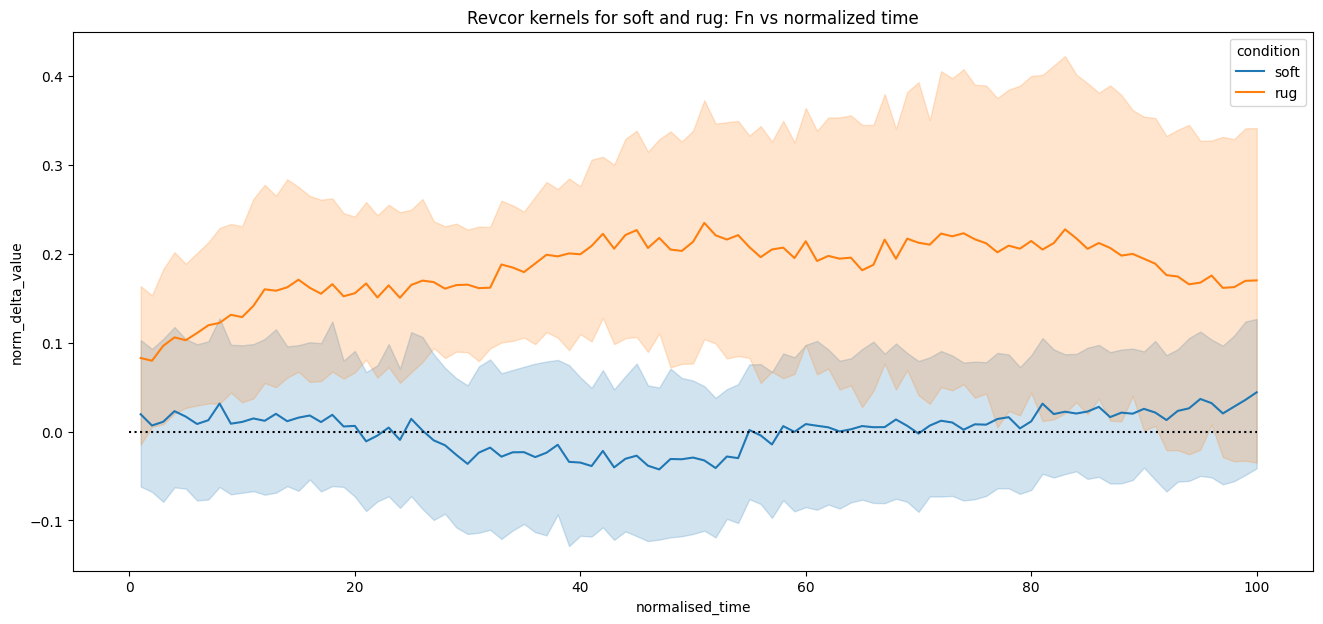

In [26]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='Fn [N]'],
              hue="condition",
             x="normalised_time",
             y="norm_delta_value", errorbar=('ci', 95))
plt.title("Revcor kernels for soft and rug: Fn vs normalized time")
plt.plot([0,100],[0,0],'k:')

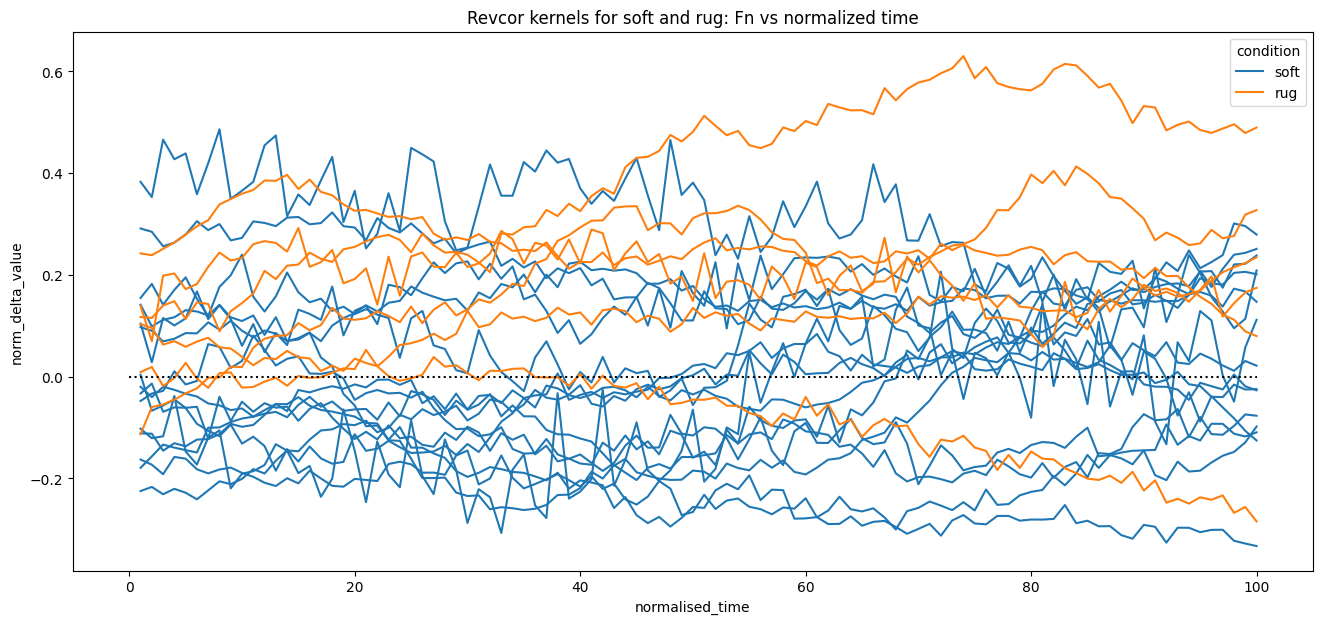

In [27]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='Fn [N]'],
              hue="condition",
             x="normalised_time",
             y="norm_delta_value", units='subj', estimator=None)
plt.title("Revcor kernels for soft and rug: Fn vs normalized time")
plt.plot([0,100],[0,0],'k:')

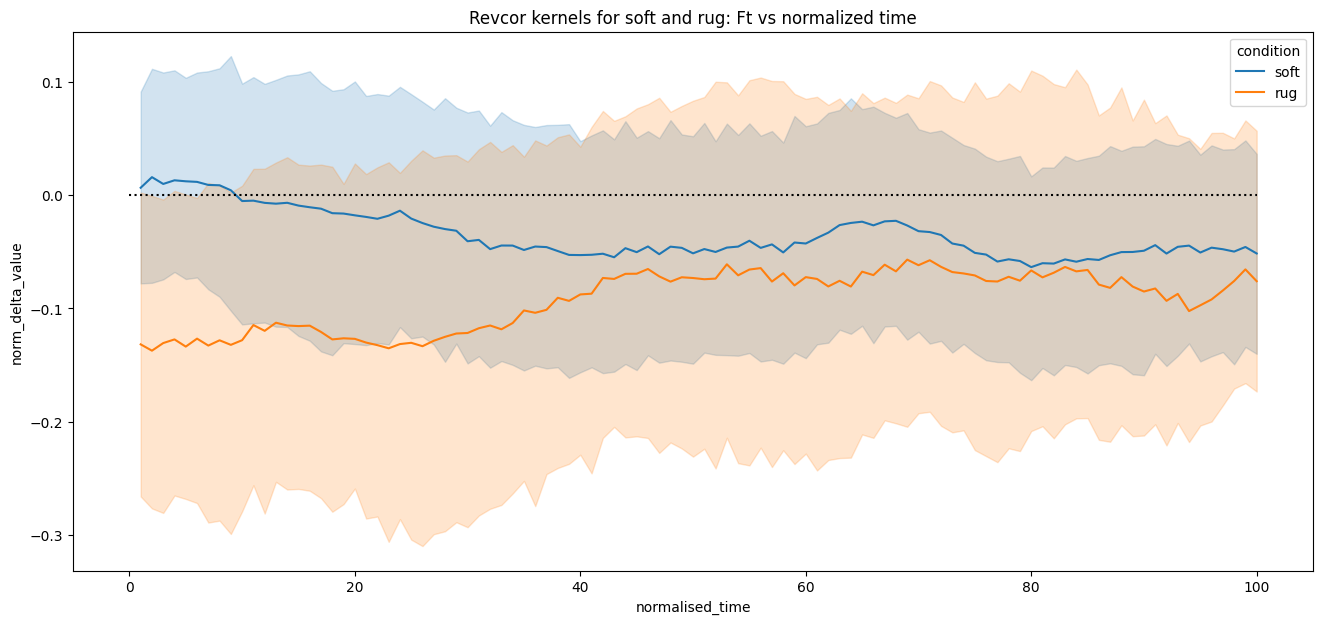

In [29]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='Ft [N]'],
              hue="condition",
             x="normalised_time",
             y="norm_delta_value", errorbar=('ci', 95))
plt.title("Revcor kernels for soft and rug: Ft vs normalized time")
plt.plot([0,100],[0,0],'k:')

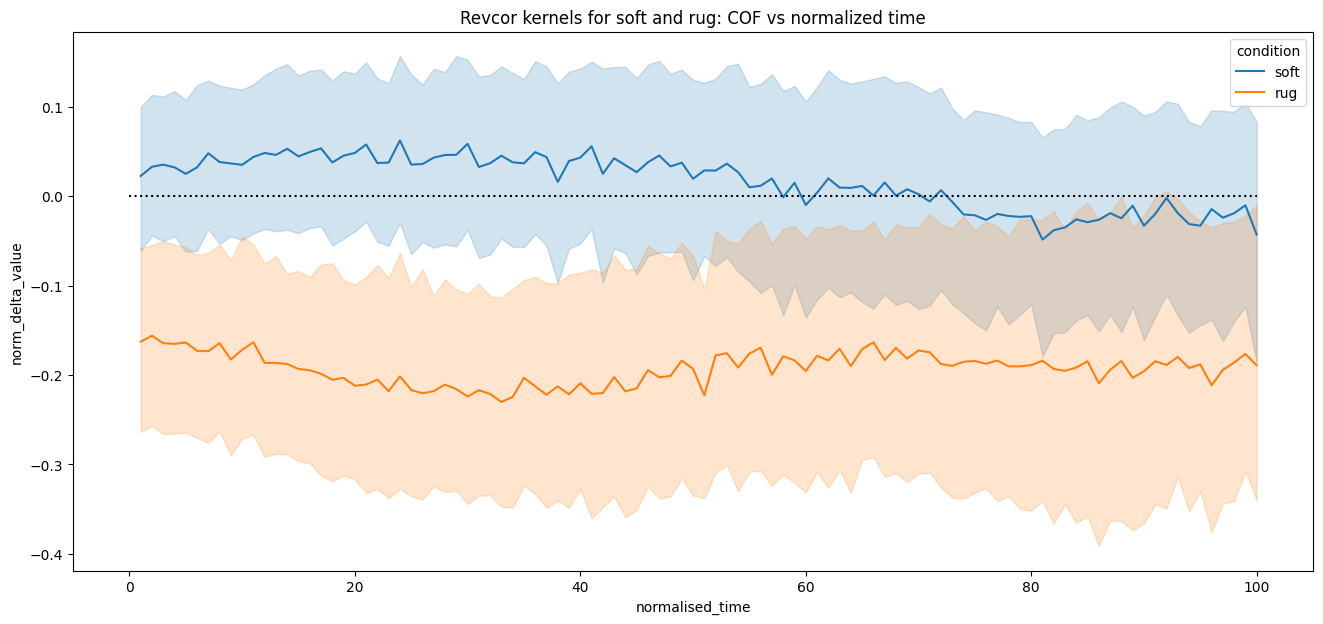

In [30]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='COF []'],
              hue="condition",
             x="normalised_time",
             y="norm_delta_value", )
plt.title("Revcor kernels for soft and rug: COF vs normalized time")
plt.plot([0,100],[0,0],'k:')

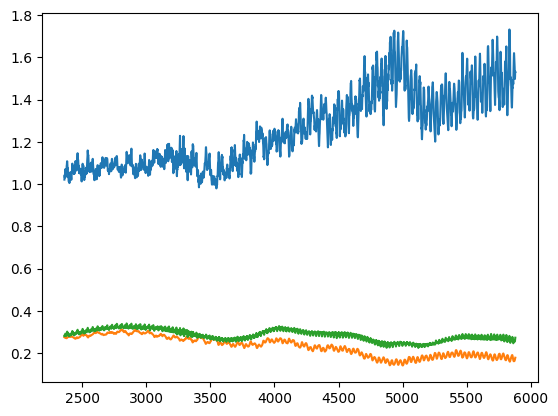

In [31]:
sig = data[(data.subj==6)&(data.block==1)&(data.trial==1)&(data.stim_order==1)]
plt.plot(sig['COF []'])
plt.plot(sig['Fn [N]'])
plt.plot(sig['Ft [N]'])


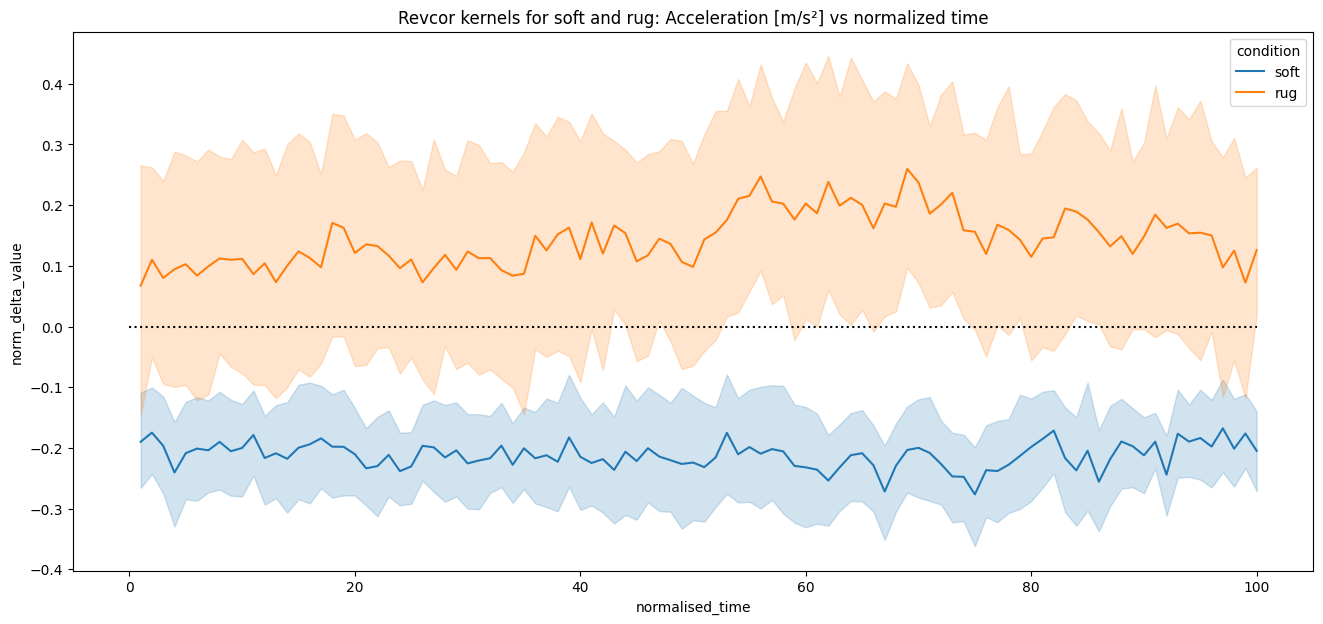

In [32]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='Acceleration [m/s²]'],
              hue="condition",
             x="normalised_time",
             y="norm_delta_value", )
plt.title("Revcor kernels for soft and rug: Acceleration [m/s²] vs normalized time")
plt.plot([0,100],[0,0],'k:')

## 2. Spectral kernels

In [33]:
from scipy.fft import fft, fftfreq

### Low-frequency Spectrum (FFt of resampled time)

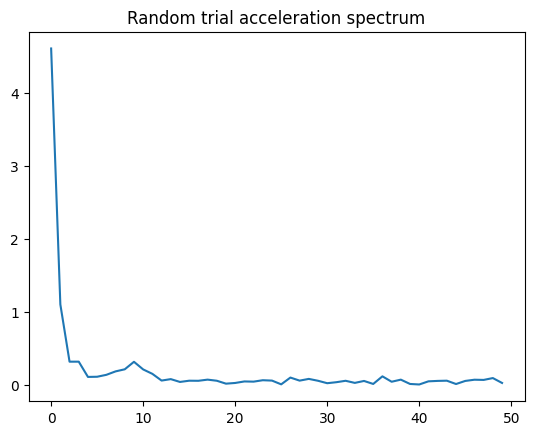

In [37]:
sig = resampled_data[(resampled_data.subj==6)&(resampled_data.block==1)&(resampled_data.trial==2)&(resampled_data.stim_order==1)]['Acceleration [m/s²]']
#plt.plot(sig)
plt.title("Random trial acceleration spectrum")
N = len(sig)
T = 1/100 # on average, 1sec duration, 100 steps
yf = fft(sig.values)
xf = fftfreq(len(sig), T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

In [47]:
data_melt

,subj,trial,block,sex,age,condition,response,stim_order,texture_id,normalised_time,feature,value
0,6,0,1,f,23,soft,False,1,E030,1,Fn [N],0.128102
1,6,0,1,f,23,soft,False,1,E030,2,Fn [N],0.132827
2,6,0,1,f,23,soft,False,1,E030,3,Fn [N],0.129126
3,6,0,1,f,23,soft,False,1,E030,4,Fn [N],0.115291
4,6,0,1,f,23,soft,False,1,E030,5,Fn [N],0.122135
...,...,...,...,...,...,...,...,...,...,...,...,...
1523195,27,24,4,m,20,rug,False,2,E075,96,Acceleration [m/s²],1.411005
1523196,27,24,4,m,20,rug,False,2,E075,97,Acceleration [m/s²],1.582401
1523197,27,24,4,m,20,rug,False,2,E075,98,Acceleration [m/s²],1.369483
1523198,27,24,4,m,20,rug,False,2,E075,99,Acceleration [m/s²],1.297563


In [54]:
def extract_fft(group):
    n = len(group)  # a group is a single mechanical signal
    group = group.reset_index(drop=True)
    T = 1/100 # on average, 1sec duration, 100 steps
    fftd = {}
    f = fft(group.value.values)
    fftd['value'] = 2.0/n * np.abs(f[0:n//2])
    new_group = pd.DataFrame(fftd)
    # Add freq
    new_group['freq'] = fftfreq(n, T)[:n//2] 
    return new_group
    
fft_data = data_melt.groupby(['subj','sex','age','condition',
                              'block','trial','stim_order',
                              'response','feature'])[['value','normalised_time']].apply(extract_fft).reset_index()# include_groups = False ?

fft_data

,subj,sex,age,condition,block,trial,stim_order,response,feature,level_9,value,freq
0,6,f,23,soft,1,0,1,False,Acceleration [m/s²],0,7.481532,0.0
1,6,f,23,soft,1,0,1,False,Acceleration [m/s²],1,2.469096,1.0
2,6,f,23,soft,1,0,1,False,Acceleration [m/s²],2,1.136347,2.0
3,6,f,23,soft,1,0,1,False,Acceleration [m/s²],3,0.540983,3.0
4,6,f,23,soft,1,0,1,False,Acceleration [m/s²],4,0.667871,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
761595,27,m,20,rug,4,24,2,False,Ft [N],45,0.000744,45.0
761596,27,m,20,rug,4,24,2,False,Ft [N],46,0.000721,46.0
761597,27,m,20,rug,4,24,2,False,Ft [N],47,0.000635,47.0
761598,27,m,20,rug,4,24,2,False,Ft [N],48,0.000818,48.0


In [55]:

# compute difference between positives and negatives in each trial
positives = fft_data.loc[fft_data.response == True].reset_index()
negatives = fft_data.loc[fft_data.response == False].reset_index()
#kernels = pd.merge(positives, negatives, on=['subj','condition', 'sex','age','block','trial','texture_id', 'normalised_time', 'feature'],suffixes=['+','-'])

kernels = pd.merge(positives, negatives, on=['subj','condition','sex','age','block','trial','feature','freq'],suffixes=['+','-'])

kernels['delta_value']=kernels['value+']-kernels['value-']  
kernels.drop(['index+', 'index-',
              'response+','response-',
              'stim_order+','stim_order-',
              'value+','value-'], axis=1, inplace=True)
kernels['square_delta_value'] = kernels['delta_value']**2
for_norm = kernels.groupby(['subj','block','trial','feature']).agg({'square_delta_value':'mean'}).reset_index()
kernels = pd.merge(kernels, for_norm, on=['subj','block','trial','feature'], suffixes=['','_mean'])
kernels['norm_delta_value'] = kernels['delta_value']/np.sqrt(kernels['square_delta_value_mean'])
kernels.drop(['delta_value','square_delta_value', 'square_delta_value_mean',], axis=1, inplace=True)
kernels = kernels.groupby(['subj','condition','feature','freq']).norm_delta_value.mean().reset_index()
 

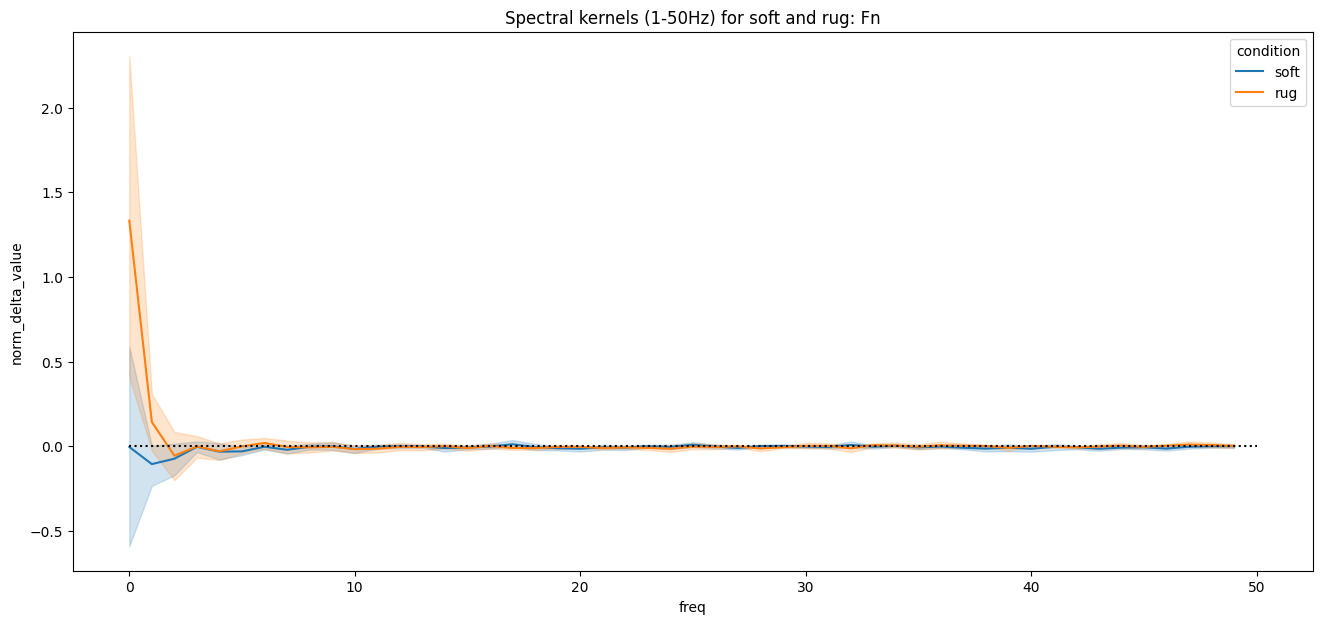

In [56]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='Fn [N]'],
              hue="condition",
             x="freq",
             y="norm_delta_value", errorbar=('ci', 95))
plt.title("Spectral kernels (1-50Hz) for soft and rug: Fn")
plt.plot([0,50],[0,0],'k:')

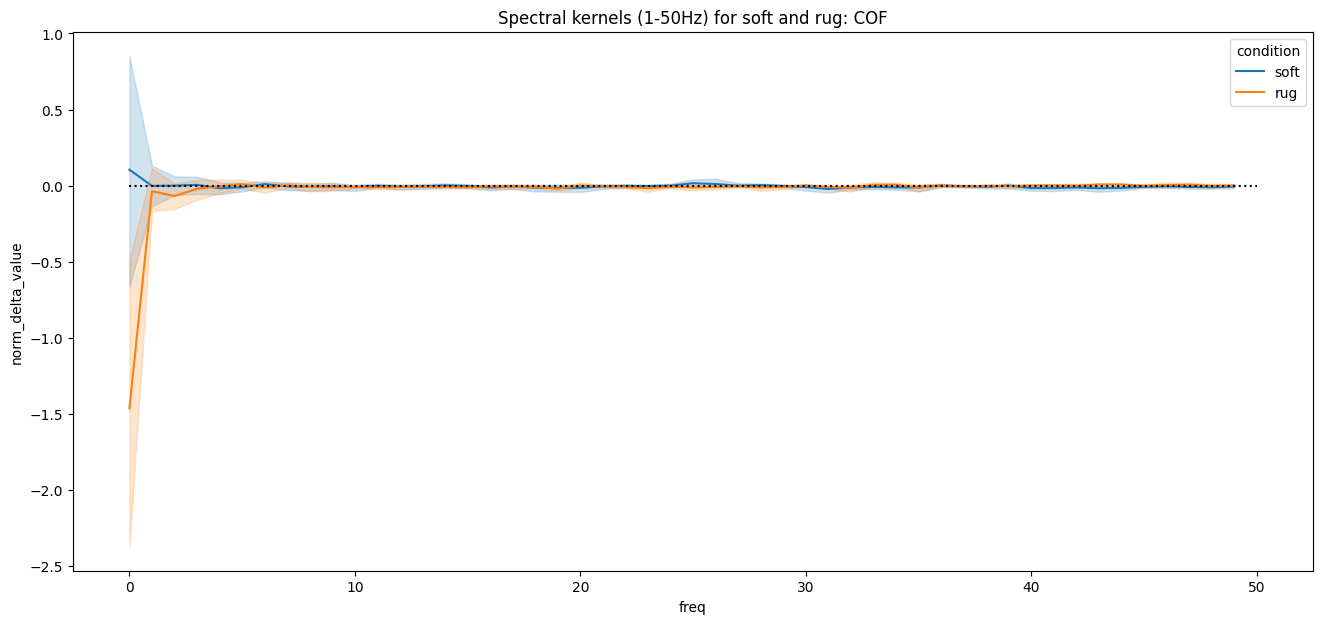

In [57]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='COF []'],
              hue="condition",
             x="freq",
             y="norm_delta_value", errorbar=('ci', 95))
plt.title("Spectral kernels (1-50Hz) for soft and rug: COF")
plt.plot([0,50],[0,0],'k:')

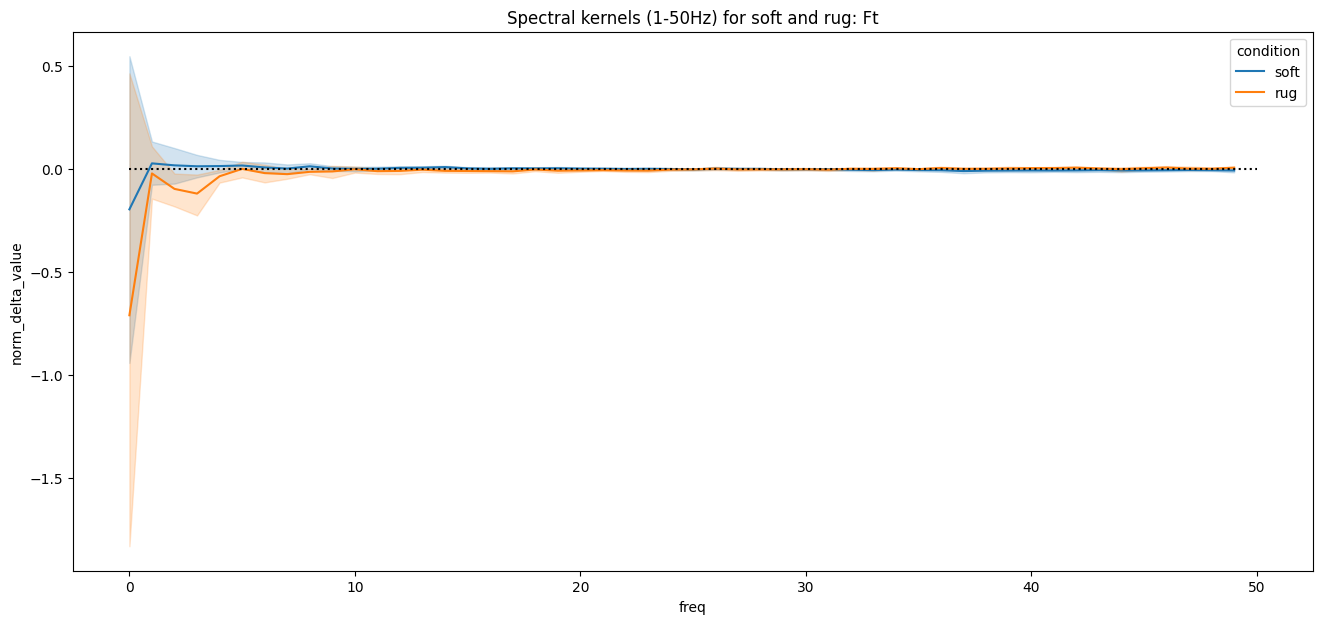

In [58]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='Ft [N]'],
              hue="condition",
             x="freq",
             y="norm_delta_value", errorbar=('ci', 95))
plt.title("Spectral kernels (1-50Hz) for soft and rug: Ft")
plt.plot([0,50],[0,0],'k:')

### High frequency spectrum

In [59]:
beha_meca_data

,subj,trial,block,practice,condition,sex,age,date,data_file,texture_id,stim_order,diameter,opening,spacing,response,rt,Displacement [mm],Fn [N],Ft [N],COF [],Acceleration [m/s²],Time [s],normalised_time
0,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,21.289894,0.132235,0.403616,3.052261,-1.965516,2.4468,1.000000
1,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,20.772082,0.130869,0.400328,3.058999,-1.472870,2.4470,1.041949
2,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,20.230913,0.129739,0.399671,3.080563,-1.637156,2.4472,1.083898
3,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,19.661823,0.128897,0.400328,3.105799,-1.670056,2.4474,1.125847
4,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,19.084907,0.128146,0.400329,3.124001,-2.162808,2.4476,1.167797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15584889,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E075,2,20.0,20.0,40.0,False,7.534,58.631441,1.323029,0.588102,0.444512,1.485856,5.2458,99.803669
15584890,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E075,2,20.0,20.0,40.0,False,7.534,58.645615,1.320701,0.590074,0.446789,3.128176,5.2460,99.852752
15584891,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E075,2,20.0,20.0,40.0,False,7.534,58.661244,1.318856,0.590403,0.447663,2.931085,5.2462,99.901834
15584892,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E075,2,20.0,20.0,40.0,False,7.534,58.678386,1.317370,0.590403,0.448168,1.945676,5.2464,99.950917


In [60]:
meca_data = pd.DataFrame()
meca_data = beha_meca_data.copy()
meca_data.drop(columns=['Acceleration [m/s²]'],inplace=True)


In [61]:
beha_meca_data_melt = pd.melt(meca_data,
        id_vars=['subj','trial','block','sex','age','condition','response', 'stim_order', 'texture_id','normalised_time'],
        value_vars=['Fn [N]','Ft [N]', 'COF []'],
        var_name='feature')


In [63]:
def extract_all_fft(group):
    n = len(group)  # number of samples in the signal
    group = group.reset_index(drop=True)
    T = 1 / 5000  # sampling interval (s)

    # Compute FFT and corresponding frequencies
    yf = 2.0 / n * np.abs(fft(group.value.values)[:n // 2])  # amplitude spectrum
    xf = fftfreq(n, T)[:n // 2]  # frequency values

    # Round frequencies to the nearest integer (1–2500 Hz range only)
    df = pd.DataFrame({
        'freq': xf,
        'value': yf
    })
    df = df[(df.freq >= 1) & (df.freq <= 2500)]  # keep only valid integer frequencies
    df['freq'] = df['freq'].round().astype(int)

    # Group by integer frequency and compute mean
    df_binned = df.groupby('freq', as_index=False)['value'].mean()

    # Ensure all frequencies from 1 to 2500 are present (fill missing with 0)
    all_freqs = pd.DataFrame({'freq': np.arange(1, 2501)})
    result = all_freqs.merge(df_binned, on='freq', how='left').fillna(0)

    return result

fft_meca_data = (
    beha_meca_data_melt.groupby(['subj','sex','age','condition','block','trial','stim_order','response','feature'])[['value','normalised_time']]
           .apply(extract_all_fft) # include_groups = False ?
           .reset_index()
)
fft_meca_data

,subj,sex,age,condition,block,trial,stim_order,response,feature,level_9,freq,value
0,6,f,23,soft,1,0,1,False,COF [],0,1,0.000000
1,6,f,23,soft,1,0,1,False,COF [],1,2,0.483248
2,6,f,23,soft,1,0,1,False,COF [],2,3,0.000000
3,6,f,23,soft,1,0,1,False,COF [],3,4,0.458450
4,6,f,23,soft,1,0,1,False,COF [],4,5,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
28559995,27,m,20,rug,4,24,2,False,Ft [N],2495,2496,0.000000
28559996,27,m,20,rug,4,24,2,False,Ft [N],2496,2497,0.000000
28559997,27,m,20,rug,4,24,2,False,Ft [N],2497,2498,0.000043
28559998,27,m,20,rug,4,24,2,False,Ft [N],2498,2499,0.000000


In [64]:
freq_data = pd.DataFrame()
freq_columns = [col for col in beha_meca_data.columns
                     if col not in ['Fn [N]','Ft [N]', 'COF []']]
freq_data[freq_columns] = beha_meca_data[freq_columns]

In [65]:
beha_freq_data_melt = pd.melt(freq_data,
        id_vars=['subj','trial','block','stim_order','sex','age','condition','response', 'texture_id','normalised_time'],
        value_vars=['Acceleration [m/s²]'],
        var_name='feature')


In [66]:
from scipy.fft import rfft, rfftfreq

def extract_freq_fft(group, fs=5000):
    n = len(group)

    T = 1.0 / fs
    freqs = rfftfreq(n, T)
    amps = 2.0 / n * np.abs(rfft(group['value'].values))

    # Remove 0 Hz
    freqs = freqs[1:]
    amps = amps[1:]

    df_fft = pd.DataFrame({'freq': freqs, 'ampl': amps})

    # Bin to integer Hz and compute mean instead of RMS
    df_fft['freq_bin'] = df_fft['freq'].round().astype(int)
    df_binned = df_fft.groupby('freq_bin')['ampl'].mean().reset_index()
    df_binned.columns = ['freq', 'value']

    # Keep only bins from 1 to 2500 Hz
    df_binned = df_binned[(df_binned['freq'] >= 1) & (df_binned['freq'] <= 2500)]

    return df_binned

fft_freq_data = (
    beha_freq_data_melt.groupby(['subj','sex','age','condition','block','trial','stim_order','response','feature'])
        .apply(extract_freq_fft) #, include_groups=False
        .reset_index()
)



In [67]:
# compute difference between positives and negatives in each trial
positives = fft_meca_data.loc[fft_meca_data.response == True].reset_index()
negatives = fft_meca_data.loc[fft_meca_data.response == False].reset_index()
#kernels = pd.merge(positives, negatives, on=['subj','condition', 'sex','age','block','trial','texture_id', 'normalised_time', 'feature'],suffixes=['+','-'])

kernels = pd.merge(positives, negatives, on=['subj','condition','sex','age','block','trial','feature','freq'],suffixes=['+','-'])

kernels['delta_value']=kernels['value+']-kernels['value-']  
kernels.drop(['index+', 'index-',
              'response+','response-',
              'stim_order+','stim_order-',
              'value+','value-'], axis=1, inplace=True)
kernels['square_delta_value'] = kernels['delta_value']**2
for_norm = kernels.groupby(['subj','block','trial','feature']).agg({'square_delta_value':'mean'}).reset_index()
kernels = pd.merge(kernels, for_norm, on=['subj','block','trial','feature'], suffixes=['','_mean'])
kernels['norm_delta_value'] = kernels['delta_value']/np.sqrt(kernels['square_delta_value_mean'])
kernels.drop(['delta_value','square_delta_value', 'square_delta_value_mean',], axis=1, inplace=True)
kernels = kernels.groupby(['subj','condition','feature','freq']).norm_delta_value.mean().reset_index()

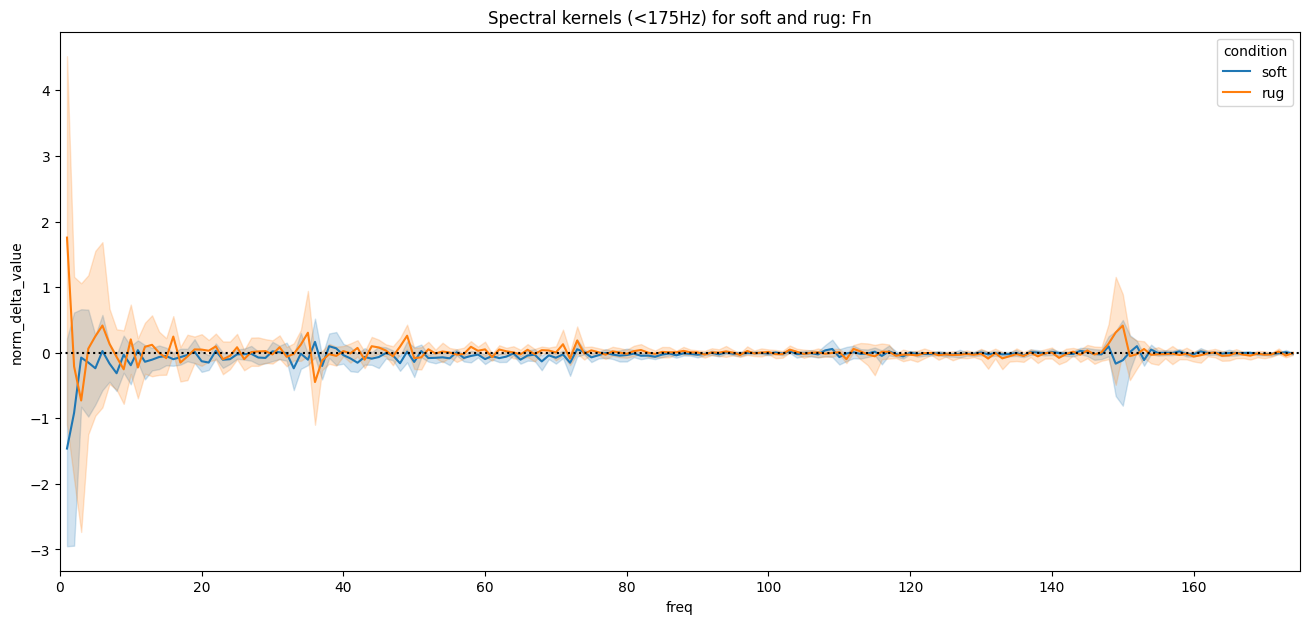

In [68]:
plt.figure(figsize=(16,7))

sns.lineplot(
    data=kernels[(kernels.feature == 'Fn [N]') & (kernels.freq < 175)],
    hue="condition",
    x="freq",
    y="norm_delta_value",
    errorbar=('ci', 95)
)

plt.title("Spectral kernels (<175Hz) for soft and rug: Fn")
plt.plot([0, 175], [0, 0], 'k:')  # Adjusted limit to match x range
plt.xlim(0, 175)  # Optional: explicitly set x-axis limits
plt.show()


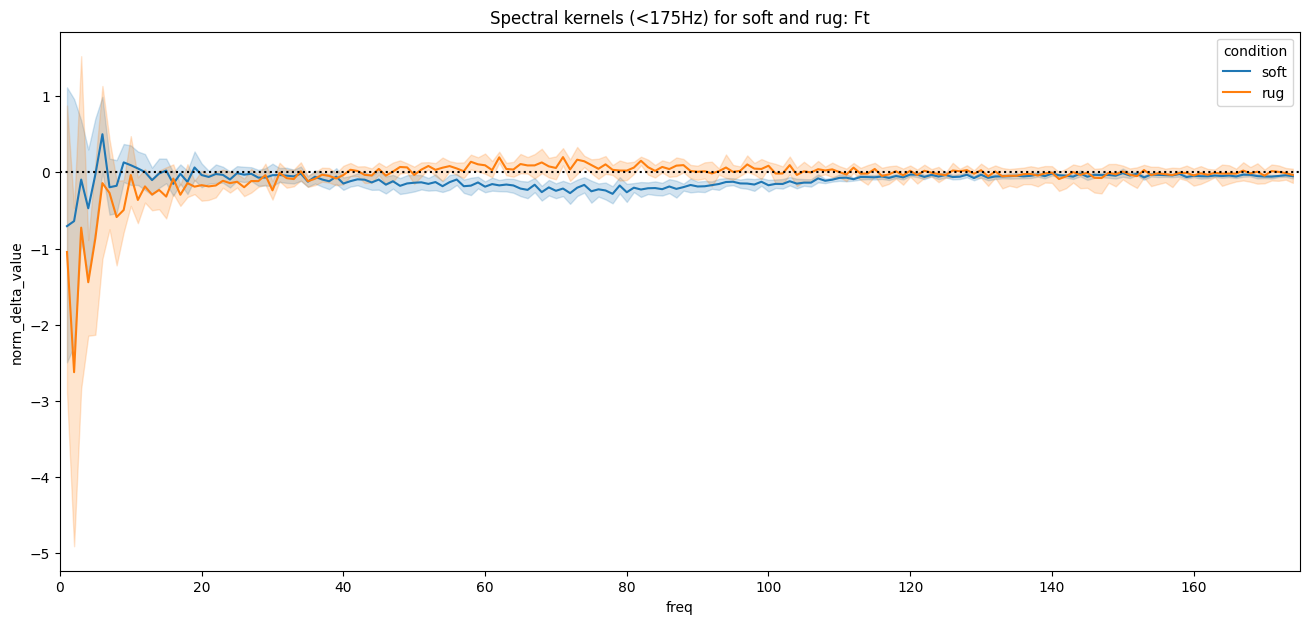

In [69]:
plt.figure(figsize=(16,7))

sns.lineplot(
    data=kernels[(kernels.feature == 'Ft [N]') & (kernels.freq < 175)],
    hue="condition",
    x="freq",
    y="norm_delta_value",
    errorbar=('ci', 95)
)

plt.title("Spectral kernels (<175Hz) for soft and rug: Ft")
plt.plot([0, 175], [0, 0], 'k:')  # Adjusted limit to match x range
plt.xlim(0, 175)  # Optional: explicitly set x-axis limits
plt.show()

In [70]:
# compute difference between positives and negatives in each trial
positives = fft_freq_data.loc[fft_freq_data.response == True].reset_index()
negatives = fft_freq_data.loc[fft_freq_data.response == False].reset_index()
#kernels = pd.merge(positives, negatives, on=['subj','condition', 'sex','age','block','trial','texture_id', 'normalised_time', 'feature'],suffixes=['+','-'])

kernels = pd.merge(positives, negatives, on=['subj','condition','sex','age','block','trial','feature','freq'],suffixes=['+','-'])

kernels['delta_value']=kernels['value+']-kernels['value-']  
kernels.drop(['index+', 'index-',
              'response+','response-',
              'stim_order+','stim_order-',
              'value+','value-'], axis=1, inplace=True)
kernels['square_delta_value'] = kernels['delta_value']**2
for_norm = kernels.groupby(['subj','block','trial','feature']).agg({'square_delta_value':'mean'}).reset_index()
kernels = pd.merge(kernels, for_norm, on=['subj','block','trial','feature'], suffixes=['','_mean'])
kernels['norm_delta_value'] = kernels['delta_value']/np.sqrt(kernels['square_delta_value_mean'])
kernels.drop(['delta_value','square_delta_value', 'square_delta_value_mean',], axis=1, inplace=True)
kernels = kernels.groupby(['subj','condition','feature','freq']).norm_delta_value.mean().reset_index()

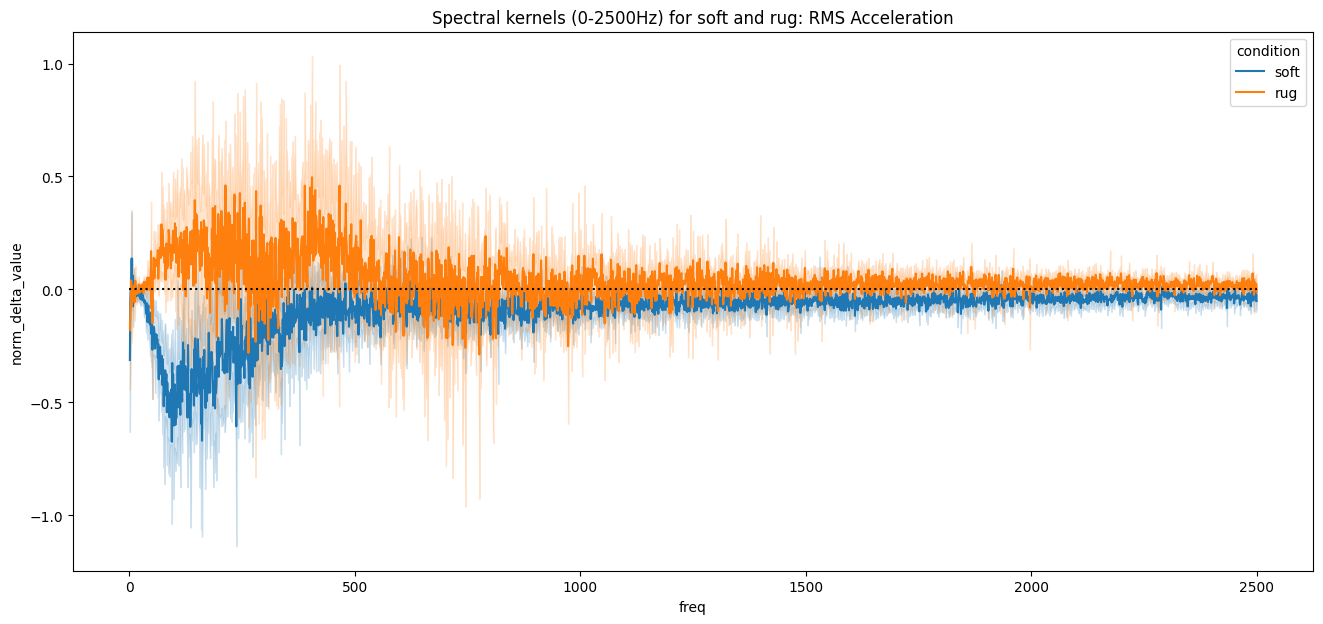

In [71]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='Acceleration [m/s²]'],
              hue="condition",
             x="freq",
             y="norm_delta_value", errorbar=('ci', 95))
plt.title("Spectral kernels (0-2500Hz) for soft and rug: RMS Acceleration")
plt.plot([0,2500],[0,0],'k:')

#### Spatial frequency (cycles/mm)

In [105]:
results_df = pd.read_csv('data/results.csv', index_col=0)

In [155]:
fft_spatial_data = fft_freq_data.copy()
fft_spatial_data = fft_spatial_data.merge(results_df, on = ['subj','trial','block', 'stim_order'], 
                                         suffixes=('','_right'))
fft_spatial_data['freq_spatiale'] = fft_spatial_data['freq'] / fft_spatial_data['v_mean_mms']

In [156]:
# 1. Round spatial frequency to create bins (you can change 2 to 0 if you want integer bins)
fft_spatial_data['freq_spatiale_bin'] = fft_spatial_data['freq_spatiale'].round(0)

# 2. Replace 'value' by the mean per (subj, trial, freq_spatiale_bin)
fft_spatial_data['value'] = (
    fft_spatial_data
    .groupby(['subj','block', 'trial', 'texture_id','freq_spatiale_bin'])['value']
    .transform('mean')
)

# 3. Drop duplicates to keep only one row per group
fft_spatial_data = fft_spatial_data.drop_duplicates(subset=['subj','block', 'trial','texture_id', 'freq_spatiale_bin'])

# 4. (Optional) Rename the bin column to something cleaner
#fft_spatial_data = fft_spatial_data.rename(columns={'freq_spatiale_bin': 'freq_spatiale'})

# 5. Reset index for clean output
fft_spatial_data = fft_spatial_data.reset_index(drop=True)

In [157]:
# compute difference between positives and negatives in each trial
positives = fft_spatial_data.loc[fft_spatial_data.response == True].reset_index()
negatives = fft_spatial_data.loc[fft_spatial_data.response == False].reset_index()
#kernels = pd.merge(positives, negatives, on=['subj','condition', 'sex','age','block','trial','texture_id', 'normalised_time', 'feature'],suffixes=['+','-'])

kernels = pd.merge(positives, negatives, on=['subj','condition','sex','age','block','trial','feature','freq_spatiale_bin'],suffixes=['+','-'])

kernels['delta_value']=kernels['value+']-kernels['value-']  
kernels.drop(['index+', 'index-',
              'response+','response-',
              'stim_order+','stim_order-',
              'value+','value-'], axis=1, inplace=True)
kernels['square_delta_value'] = kernels['delta_value']**2
for_norm = kernels.groupby(['subj','block','trial','feature']).agg({'square_delta_value':'mean'}).reset_index()
kernels = pd.merge(kernels, for_norm, on=['subj','block','trial','feature'], suffixes=['','_mean'])
kernels['norm_delta_value'] = kernels['delta_value']/np.sqrt(kernels['square_delta_value_mean'])
kernels.drop(['delta_value','square_delta_value', 'square_delta_value_mean',], axis=1, inplace=True)
kernels = kernels.groupby(['subj','condition','feature','freq_spatiale_bin']).norm_delta_value.mean().reset_index()

In [158]:
kernels['period_um'] = 1000/kernels.freq_spatiale_bin

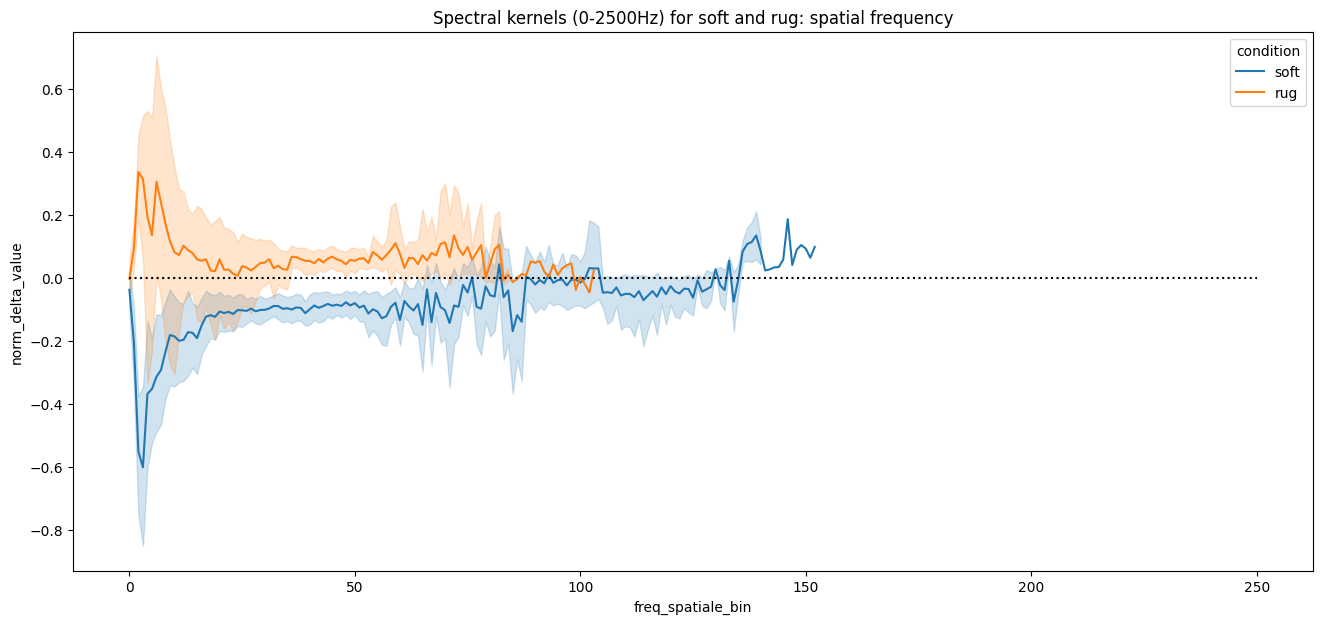

In [159]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='Acceleration [m/s²]'],
              hue="condition",
             x="freq_spatiale_bin",
             y="norm_delta_value", errorbar=('ci', 95))
plt.title("Spectral kernels (0-2500Hz) for soft and rug: spatial frequency")
plt.plot([0,250],[0,0],'k:')

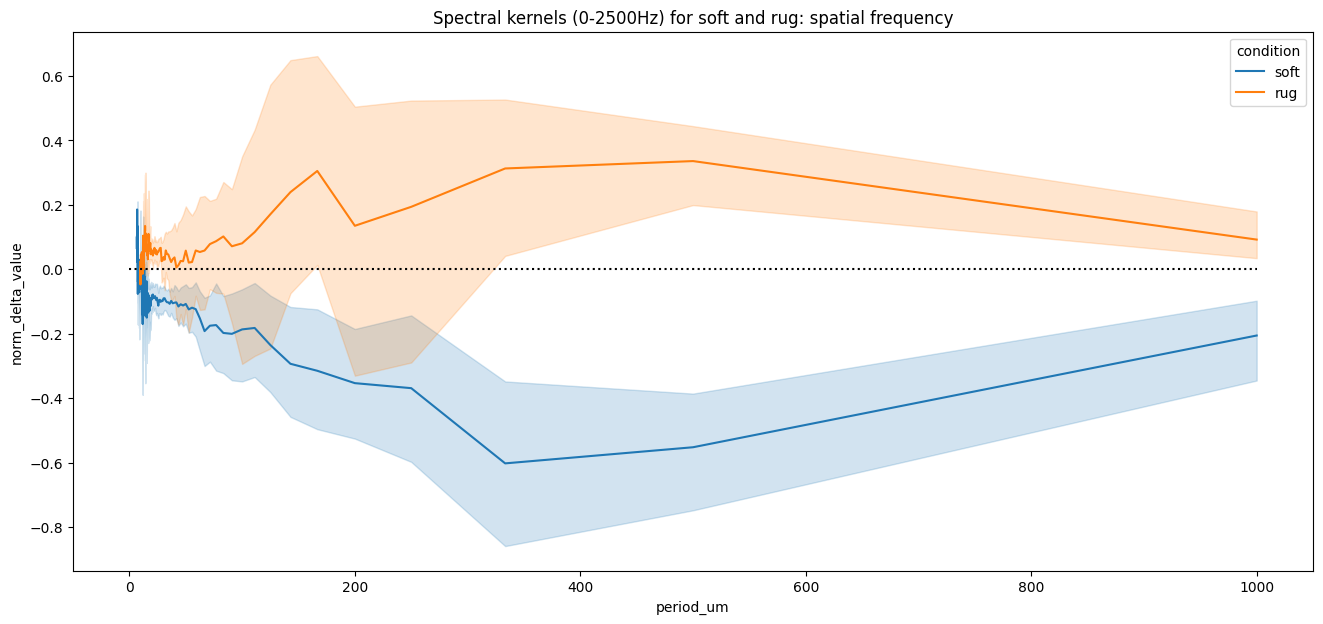

In [160]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='Acceleration [m/s²]'],
              hue="condition",
             x="period_um",
             y="norm_delta_value", errorbar=('ci', 95))
plt.title("Spectral kernels (0-2500Hz) for soft and rug: spatial frequency")
plt.plot([0,1000],[0,0],'k:')

Ft et Fn

In [140]:
fft_spatial_data = fft_meca_data.copy()
fft_spatial_data = fft_spatial_data.merge(results_df, on = ['subj','trial','block', 'stim_order'], 
                                         suffixes=('','_right'))
fft_spatial_data['freq_spatiale'] = fft_spatial_data['freq'] / fft_spatial_data['v_mean_mms']

In [141]:
# 1. Round spatial frequency to create bins (you can change 2 to 0 if you want integer bins)
fft_spatial_data['freq_spatiale_bin'] = fft_spatial_data['freq_spatiale'].round(0)

# 2. Replace 'value' by the mean per (subj, trial, freq_spatiale_bin)
fft_spatial_data['value'] = (
    fft_spatial_data
    .groupby(['subj','block', 'trial', 'texture_id','freq_spatiale_bin', 'feature'])['value']
    .transform('mean')
)

# 3. Drop duplicates to keep only one row per group
fft_spatial_data = fft_spatial_data.drop_duplicates(subset=['subj','block', 'trial','texture_id', 'feature','freq_spatiale_bin'])

# 4. (Optional) Rename the bin column to something cleaner
#fft_spatial_data = fft_spatial_data.rename(columns={'freq_spatiale_bin': 'freq_spatiale'})

# 5. Reset index for clean output
fft_spatial_data = fft_spatial_data.reset_index(drop=True)

In [142]:
# compute difference between positives and negatives in each trial
positives = fft_spatial_data.loc[fft_spatial_data.response == True].reset_index()
negatives = fft_spatial_data.loc[fft_spatial_data.response == False].reset_index()
#kernels = pd.merge(positives, negatives, on=['subj','condition', 'sex','age','block','trial','texture_id', 'normalised_time', 'feature'],suffixes=['+','-'])

kernels = pd.merge(positives, negatives, on=['subj','condition','sex','age','block','trial','feature','freq_spatiale_bin'],suffixes=['+','-'])

kernels['delta_value']=kernels['value+']-kernels['value-']  
kernels.drop(['index+', 'index-',
              'response+','response-',
              'stim_order+','stim_order-',
              'value+','value-'], axis=1, inplace=True)
kernels['square_delta_value'] = kernels['delta_value']**2
for_norm = kernels.groupby(['subj','block','trial','feature']).agg({'square_delta_value':'mean'}).reset_index()
kernels = pd.merge(kernels, for_norm, on=['subj','block','trial','feature'], suffixes=['','_mean'])
kernels['norm_delta_value'] = kernels['delta_value']/np.sqrt(kernels['square_delta_value_mean'])
kernels.drop(['delta_value','square_delta_value', 'square_delta_value_mean',], axis=1, inplace=True)
kernels = kernels.groupby(['subj','condition','feature','freq_spatiale_bin']).norm_delta_value.mean().reset_index()

In [148]:
kernels['period_um'] = 1000/kernels.freq_spatiale_bin

(-1.0, 10.0)

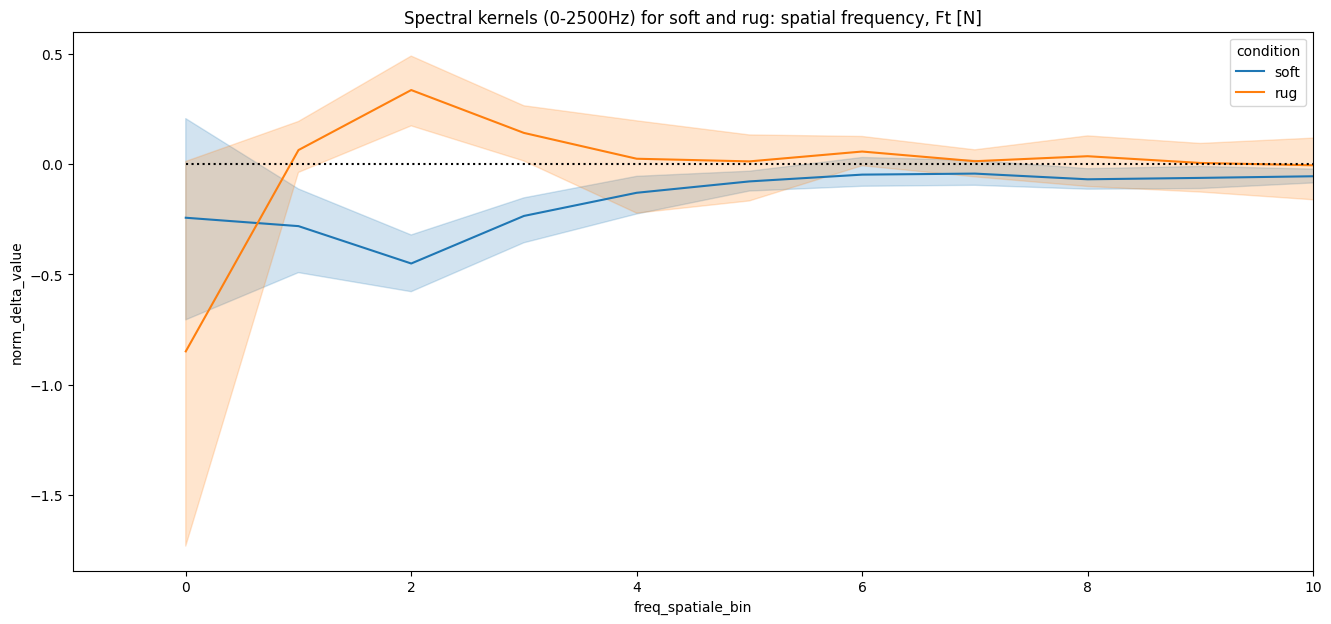

In [150]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='Ft [N]'],
              hue="condition",
             x="freq_spatiale_bin",
             y="norm_delta_value", errorbar=('ci', 95))
plt.title("Spectral kernels (0-2500Hz) for soft and rug: spatial frequency, Ft [N]")
plt.plot([0,250],[0,0],'k:')
plt.xlim([-1,10])

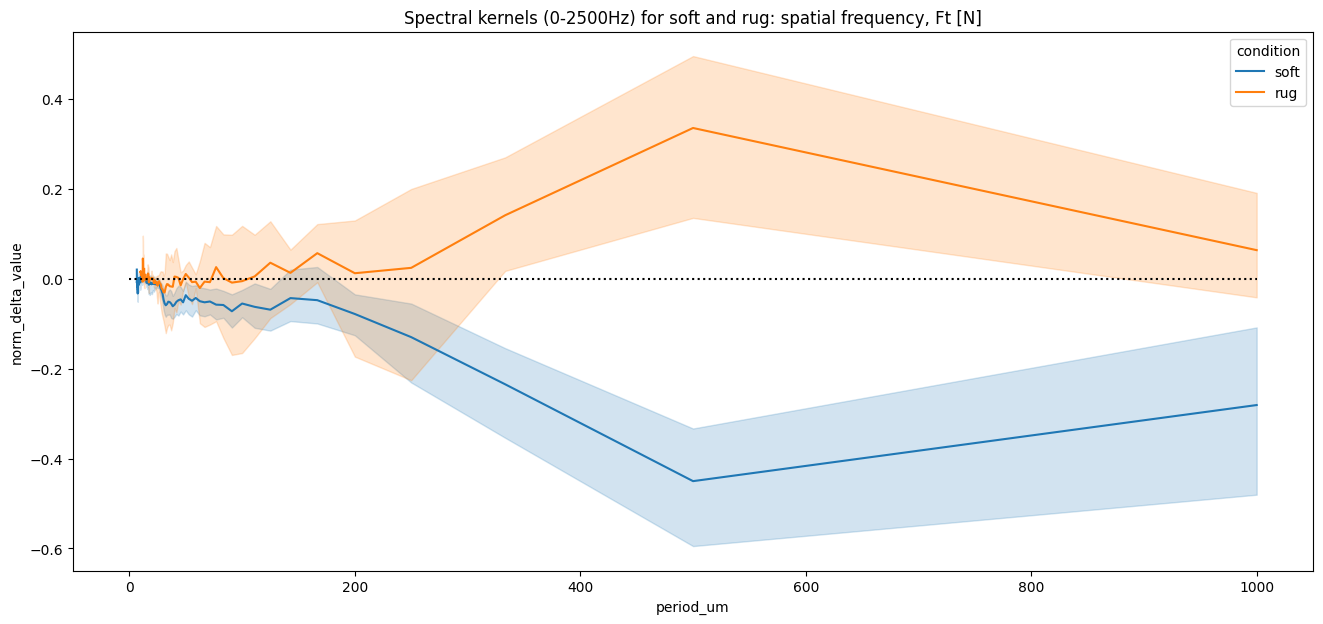

In [152]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='Ft [N]'],
              hue="condition",
             x="period_um",
             y="norm_delta_value", errorbar=('ci', 95))
plt.title("Spectral kernels (0-2500Hz) for soft and rug: spatial frequency, Ft [N]")
plt.plot([0,1000],[0,0],'k:')
#plt.xlim([-1,10])

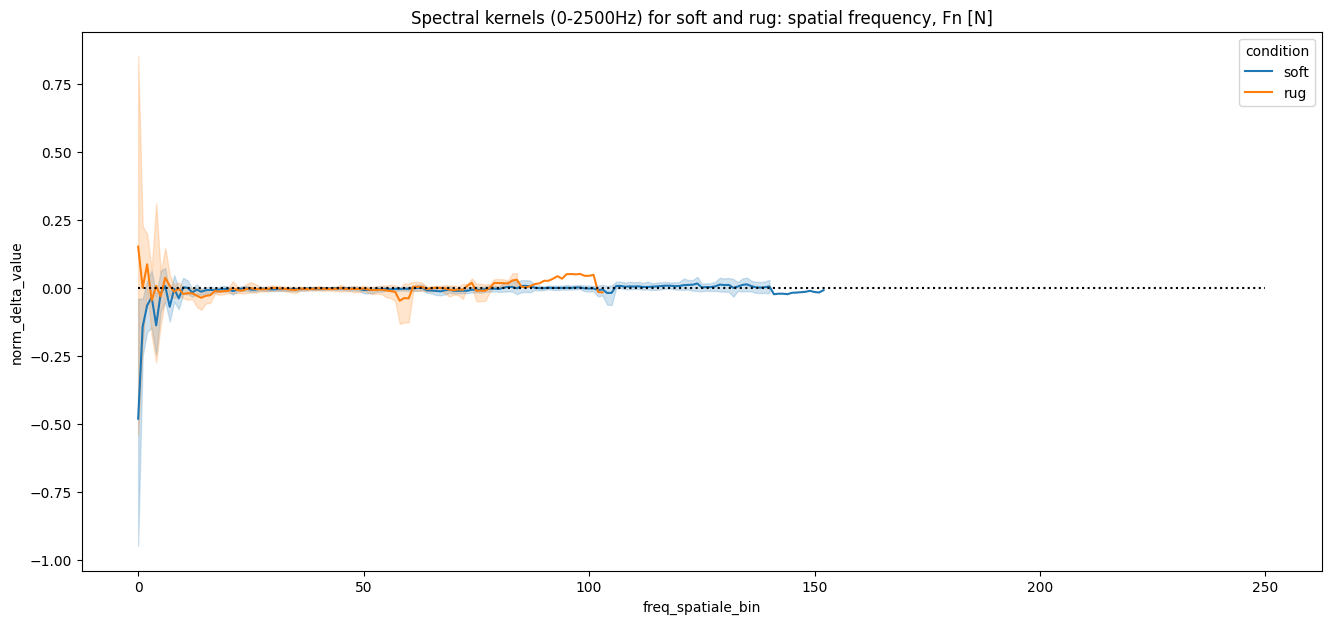

In [144]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='Fn [N]'],
              hue="condition",
             x="freq_spatiale_bin",
             y="norm_delta_value", errorbar=('ci', 95))
plt.title("Spectral kernels (0-2500Hz) for soft and rug: spatial frequency, Fn [N]")
plt.plot([0,250],[0,0],'k:')

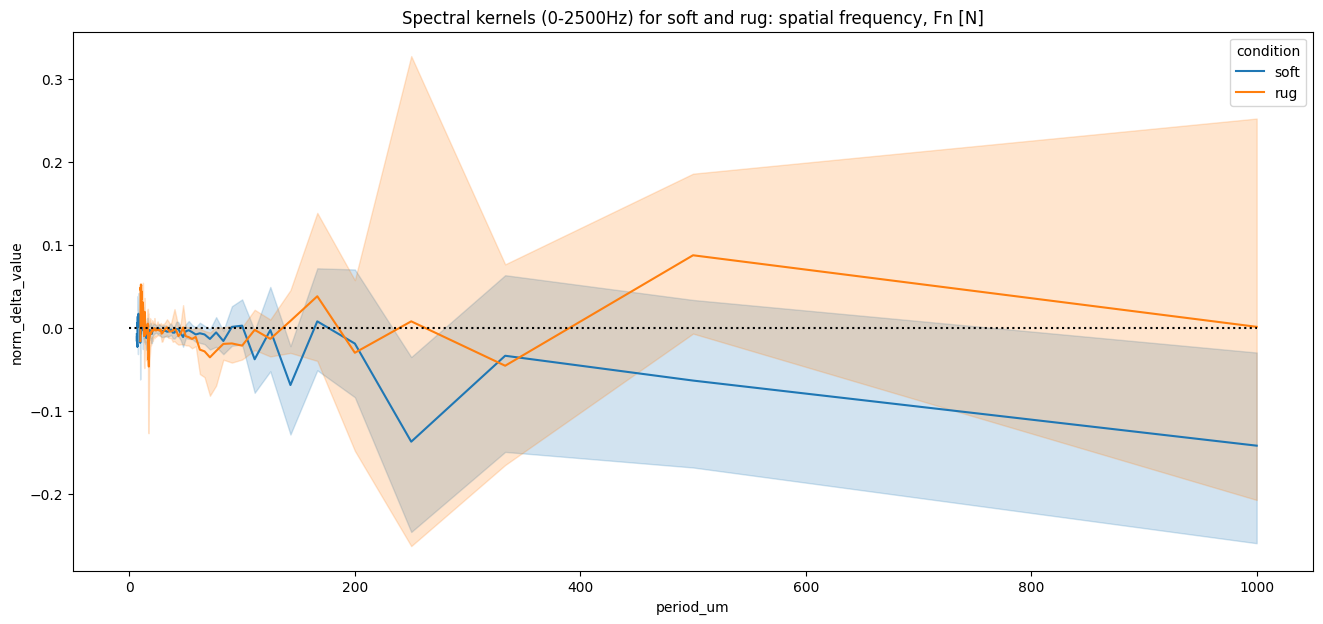

In [154]:
plt.figure(figsize=(16,7))
sns.lineplot(data=kernels[kernels.feature=='Fn [N]'],
              hue="condition",
             x="period_um",
             y="norm_delta_value", errorbar=('ci', 95))
plt.title("Spectral kernels (0-2500Hz) for soft and rug: spatial frequency, Fn [N]")
plt.plot([0,1000],[0,0],'k:')
#plt.plot([0,250],[0,0],'k:')

# Acceleration Normalisation :

In [48]:
df = pd.read_csv('data/meca/meca.csv',index_col=0)
pd.set_option('display.max_columns',df.shape[1])
df.drop(columns={'index'},inplace=True)

In [49]:
zscore = lambda x: (x-np.nanmean(x))/np.nanstd(x)
d = df
d['rms_accelero_ms_norm'] = d.groupby(['subj']).rms_accelero_ms.transform(zscore)
d['v_mean_mms_norm'] = d.groupby(['subj']).v_mean_mms.transform(zscore)

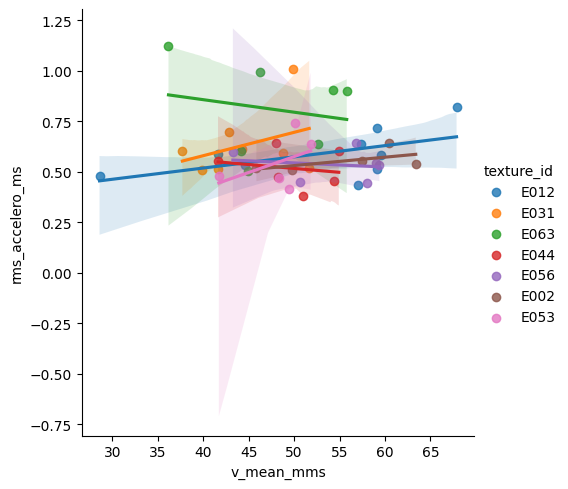

In [50]:
d = pd.read_csv('data/results.csv')
subjs = 21
textures= d[d.subj==subjs].groupby('texture_id').trial.count().sort_values(ascending=False).head(7).index.to_list()
sns.lmplot(data=d[(d.subj==subjs)], x='v_mean_mms',y='rms_accelero_ms', hue='texture_id', hue_order=textures)

In [51]:
from scipy.stats import linregress
d = pd.read_csv('data/results.csv')
all_results = []
for subjs in d.subj.unique() :
    textures= d[d.subj==subjs].groupby('texture_id').trial.count().sort_values(ascending=False).head(10).index.to_list()
    for texture in textures : 
        slope, intercept, r_value, p_value, std_err = linregress(d[(d.subj==subjs)&(d.texture_id==texture)]['v_mean_mms'], d[(d.subj==subjs)&(d.texture_id==texture)]['rms_accelero_ms'])
        result = {
        'subj': subjs,
        'texture_id': texture,
        'slope': slope,
        'R2': r_value
        }
        all_results.append(result)
        slope_intercept = pd.DataFrame(all_results)



In [52]:
slope_intercept

,subj,texture_id,slope,R2
0,6,E010,0.021034,0.656708
1,6,E036,0.032072,0.487776
2,6,E071,0.021394,0.697182
3,6,E074,0.037575,0.537321
4,6,E025,-0.033896,-0.317965
...,...,...,...,...
205,27,E014,-0.010659,-0.376646
206,27,E030,0.025270,0.799034
207,27,E002,0.375823,0.778697
208,27,E064,0.071571,0.806212


In [53]:
slope_intercept.describe()

,subj,slope,R2
count,210.000000,210.000000,210.000000
mean,16.333333,0.026725,0.281533
std,6.461763,0.212463,0.464349
min,6.000000,-0.998148,-0.961717
25%,11.000000,-0.002518,-0.048537
50%,16.000000,0.011997,0.352264
75%,22.000000,0.038262,0.657181
max,27.000000,2.204257,0.992234


In [54]:
df_result = pd.read_csv('data/results.csv')
results = pd.DataFrame()
results['subj'] = df_result['subj']
results['condition'] = df_result['condition']
slope_intercept = pd.merge(slope_intercept,results,on=['subj'])

Text(0.5, 1.0, 'Slope per subject')

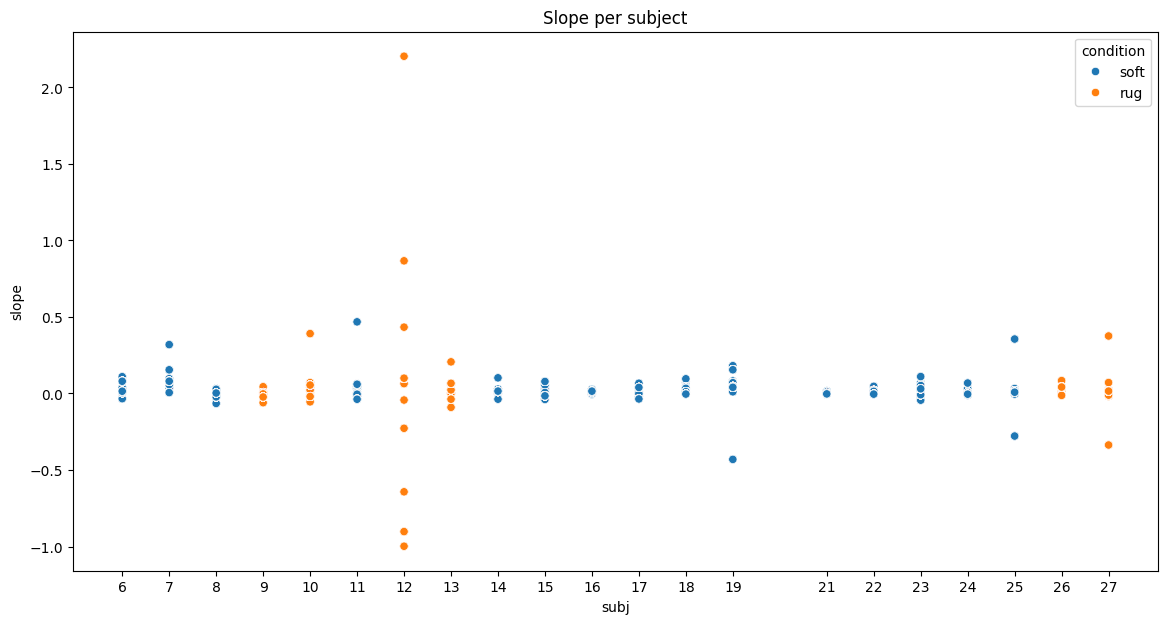

In [55]:
plt.figure(figsize=(14,7))
sns.scatterplot(data=slope_intercept.reset_index(), x='subj' ,y='slope',hue='condition')
plt.xticks(slope_intercept.subj.unique()) 
plt.title("Slope per subject")

(-2.0, 2.0)

<Figure size 1400x700 with 0 Axes>

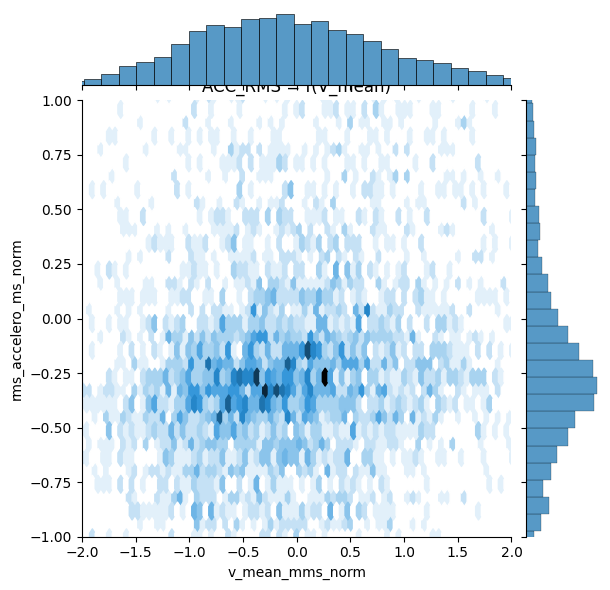

In [56]:
plt.figure(figsize=(14,7))
d=df
sns.jointplot(x=d.v_mean_mms_norm,y=d.rms_accelero_ms_norm, kind="hex", joint_kws=dict(gridsize=200))
plt.title("ACC_RMS = f(V_mean)")
plt.ylim([-1,1])
plt.xlim([-2,2])
